# The effect of chemical environment and temperature on the domain structure of free-standing $BaTiO_3$ via in-situ STEM

### Authors
Tamsin O’Reilly, PhD<br>
Kristina Holsgrove<br>
Xinqiao Zhang<br>
John Scott<br>
Iaroslav Gaponenko, PhD<br>
Praveen Kumar, PhD<br>
Joshua Agar, PhD<br>
Patrycja Paruch, PhD<br>
Miryam Arredondo

### Keywords
BaTiO3 free-standing film, chemical environment, in-situ heating TEM, domains.
***

## Abstract
Ferroelectrics, due to their polar nature and reversible switching, can be used to dynamically control surface chemistry for catalysis, chemical switching, and other applications such as water splitting. However, this is a complex phenomenon where ferroelectric domains orientation and switching are intimately linked to surface charges. In this work, we study the temperature-induced domain behavior of ferroelectric-ferroelastic domains in free-standing BaTiO3 films under different gas environments,including reducing and oxidizing by in-situ scanning transmission electron microscopy(STEM). We also establish an automated pathway to statistically disentangle and detect domain structure transformations using deep autoencoders, providing a pathway towards real-time analysis. Our results show a clear difference in the temperature at which phase transition occur and domain behaviour between the environments, with a peculiar domain reconfiguration at low temperatures, from a-c to a-a at ~60°C. The reducing environment exhibits a rich domain structure, while under the oxidizing environment, the domain structure is largely suppressed. The direct visualization provided by in-situ gas and heating STEM is a novel technique that allows the study that external variables such as gas, pressure, and temperature have on oxide surfaces in a dynamic manner, which is of particular interest for further understanding surface-screening mechanisms in ferroelectrics.
***

## Imports

In [1]:
# For the notebook to work you must have m3_learning installed
# !pip install m3-learning

In [2]:
import sys
import matplotlib.pyplot as plt
import warnings
import torch

# warnings.filterwarnings("ignore")
# # if you want to modify files,
# # edit this to match the location whwere you downloaded the m3_learning package
# m3_package_location = '/home/xinqiao/' 
# sys.path.append(f"{m3_package_location}/m3_learning/m3_learning/src")

In [3]:
%load_ext autoreload
%autoreload 2 

In [6]:
from m3_learning.viz.printing import printer
from m3_learning.viz.style import set_style
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.Bright_Field_NN.Dataset import Bright_Field_Dataset
from m3_learning.nn.Bright_Field_NN.Viz import Viz
from m3_learning.nn.Bright_Field_NN.Autoencoder import ConvAutoencoder
from m3_learning.viz.layout import layout_fig, labelfigs
from m3_learning.util.file_IO import download_and_unzip

# Specify the `save_path`` where you saved your data 
# modify `save_path` and `fig_path` to fit your own file system
save_path = './../../../Data/2023_Bright_Field'
fig_path = save_path.replace("Data", "Figures") + '/'

## Loading Data from Zenodo

In [1]:
# # list of files to download from zenodo
# # uncomment this if you need to download the files from zenodo
# files = [ r'Annealed.zip',
#           r'Nitrogen.zip',
#           r'Oxygen.zip',
#           r'Vacuum.zip',
#           r'Annealed_epoch%2000043_trainloss%200.2921_coef%205.0000E-08.pkl',
#           r'Nitrogen_epoch_00060_trainloss_0.2925_coef_9.0000E-08.pkl',
#           r'Oxygen_epoch_00037_trainloss_0.3050_coef_5.0000E-08.pkl',
#           r'Vacuum_epoch_00137_trainloss_0.3150_coef_3.0250E-07.pkl'
# ]

# # downloads all the files
# for file in files:
#     # Download the data file from Zenodo
#     url = f"https://zenodo.org/record/10092383/files/{file}?download=1"

#     # download the file
#     download_and_unzip(file, url, save_path)

## Setting up Dataset

Note: 
* Make sure your data is saved in the format `"*/{some folder name}/{Ramp_Up or Ramp_Down}/{temperature}.png"`. This will ensure the images are read into the h5 file in the correct order.
* The resulting h5 file will be saved in the same folder of the `"{some folder name}"`

### Create dataset object
This dataset will contain your cropped images and windows 

In [99]:
# defines Dataset object using images from specified folder
dset = Bright_Field_Dataset(datapath = f'{save_path}/Annealed',
                            combined_name = 'Annealed',
                            verbose=False)

In [206]:
# list paths of image data in order
dset.get_temp_paths()[:5]

['./../../../Data/2023_Bright_Field/Annealed/Ramp_Up/23.png',
 './../../../Data/2023_Bright_Field/Annealed/Ramp_Up/30.png',
 './../../../Data/2023_Bright_Field/Annealed/Ramp_Up/40.png',
 './../../../Data/2023_Bright_Field/Annealed/Ramp_Up/50.png',
 './../../../Data/2023_Bright_Field/Annealed/Ramp_Up/60.png']

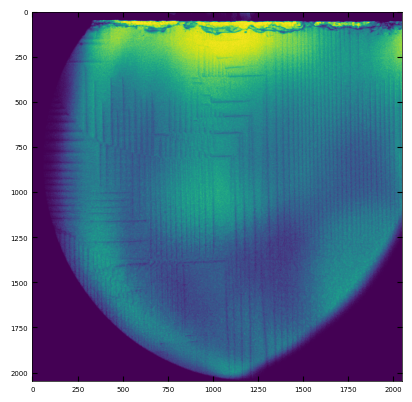

In [104]:
# Look at a raw image using the state/temperature
im = dset.get_raw_img(state = 'Ramp_Up',
                 temperature = 23)
plt.imshow(im)
plt.show()

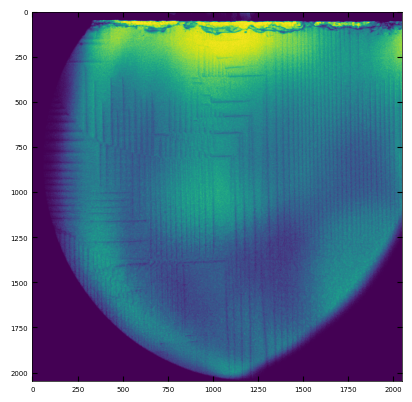

In [107]:
# Look at a raw image using index
im = dset.get_raw_img(path_index=0)
plt.imshow(im)
plt.show()

### Creating Visualization object
This contains tools for visualizing raw data and training results. It also lahys out figures

In [ ]:
# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png','svg'])

# Set the style of the plots
set_style("printing")

In [192]:
# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png','svg'],verbose=False)

# Set the style of the plots
set_style("printing")

# create vizualizer object
viz = Viz(dset,printer=printing)

# add scalebar
# Note that this should be the scalebar for the raw images
viz.scalebar_ = {"units": "nm", # choose units
                 "width": 273.4, # width of the raw image 
                 "scale length": 50 # width you want for the colorbar
                 }


printing set for seaborn


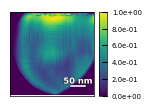

In [194]:
# view raw image. You can use
img_name = ['Ramp_Up','23']
viz.view_raw(img_name)

## Preprocessing

1. Images were cropped, and Gaussian background subtraction was applied. This result is written to the dataset named 'All_filtered' in the h5 file. 
2. The Pycroscopy package  was  used  to  sample  (128,128)  sized  sliding  windows  and  apply  a  Hanning  window and Fast Fourier Transform (FFT). Applying  FFT  to  windowed  images  provides  localized information  about  periodicity  and  reduces  bias  caused  by  sample  warping. In standard TEM, the FFT is used to calculate things such as lattice (d) spacing and planar orientation.
3. The logarithm is applied, along with a threshold and standard scaling.
4. The preprocessed data is a stack of (128,128) windows of length $T•n•n$, where $T$ is the number of temperatures sampled and $n$ is the number of windows sampled along  each  side  of  the  image.

In [86]:
# Write image data to h5 file (DO ONE TIME)
# saves original images as well as 
# cropped images with gaussian filter applied
# Make sure your cropped image size is divisible by the windowing step
dset.write_h5(200,300,1400)

100%|██████████| 43/43 [00:19<00:00,  2.15it/s]


In [89]:
# Customize window parameters
# This will run very slow for small step sizes
window_parameters = {'fft_mode': 'abs',
                    'mode': 'fft',
                    'window_size_x': 128,
                    'window_size_y': 128,
                    'window_step_x': 32,
                    'window_step_y': 32,
                    'zoom_factor': 2,
                    'interpol_factor': 2.3,
                    'filter': 'hamming'}

# Write windows
wins = dset.write_windows(window_parms=window_parameters,
                          overwrite=True,
                          windows_group='old_windows',
                          filter_threshold=5)

100%|██████████| 43/43 [07:19<00:00, 10.23s/it]


In [88]:
# You can also look at the dataset file this way, if you want to open it in the notebook. 
# but you are more likely to corrupt the file
h = dset.open_combined_h5()
print(h.keys())

# Be sure to close the file after use
h.close()
h

<KeysViewHDF5 ['All', 'All_filtered']>


<Closed HDF5 file>

In [125]:
# Get information on the h5 combined file
k = dset.get_combined_h5_info()

<HDF5 group "/" (3 members)>
	<HDF5 dataset "All": shape (43, 1400, 1400), type "<f4">
	<HDF5 dataset "All_filtered": shape (43, 1400, 1400), type "<f4">
	<HDF5 group "/old_windows" (3 members)>
		<HDF5 group "/old_windows/filler" (1 members)>
			<HDF5 group "/old_windows/filler/windows" (6 members)>
				<HDF5 dataset "WindowX": shape (147,), type "<f8">
				<HDF5 dataset "WindowY": shape (147,), type "<f8">
				<HDF5 dataset "a": shape (41,), type "<f8">
				<HDF5 dataset "b": shape (41,), type "<f8">
				<HDF5 group "/old_windows/filler/windows/metadata" (0 members)>
				<HDF5 dataset "windows": shape (41, 41, 147, 147), type "<f4">
		<HDF5 dataset "windows_data": shape (72283, 147, 147), type "<f4">
		<HDF5 dataset "windows_logdata": shape (72283, 128, 128), type "<f4">


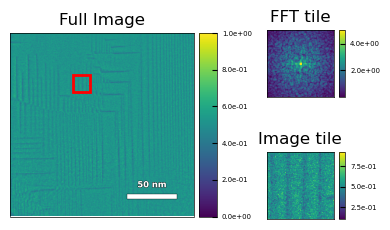

In [195]:
# view windows
img_name = ['Ramp_Up','23']
viz.view_window(img_name,15,10,
                '/old_windows/windows_logdata')

# Training

Next,  the  FFT dataset   runs   through   a   model   inspired   by   the   joint   rotationally-invariant variational autoencoder, where input is compressed into a latent space with an additional discrete rotation representation, then reconstructed to  compare to  the original image. The model used in this  article  disentangles  the  input  datasets  scaling,  rotational,  and  translational  elements  and appends them to the latent representation. 

The encoder receives a batch of (128,128) images, which are downsampled and flattened to a feature vector with 8 points, as shown in Figure 2b. 

The  feature  vector  is  then  used  to  construct  three  affine  matrices,  with  the  first  two  points corresponding to the x and y scaling, the third point to the rotation angle, and the fourth and fifth points to the x and y translation. The eight features and selected affine transformations are shown in SI video.

The scaling, rotation, and translation matrices were then used to generate three respective affine grids with shape (2,2,2), and the final latent representation concatenates the feature vector and affine grids. 

Finally, the feature vector and spatial transformer grids are flattened  and  used  to  reconstruct  the  original  input.  

The  model  parameters  are  tuned  during training using the loss function shown in Figure2e. The Mean-Squared-Error(MSE) between the input and reconstructed images tests the latent representation for completeness, while L1 Regularization encourages sparsity and prevents overfitting.

![Model structure](Final_Model.jpg)

Tips:
* `embedding_size` should be $2n^2$. This generates an affine grid is of shape $(b,1,n,n)$ in the latent space. (ex. `embedding_size` can be $2*2*2 = 8$ or $2*3*3 = 18$)
* Don't make $n$ too big. The final output will be of shape $(b,4,2*n*n)$ because we stack the affine grids for decoding
* If nothing saved, it is because your model is not improving. The model only saves if the loss is less than the last best loss

In [143]:
# defined model parameters
encoder_step_size = (128,128)
# [dset.get_shape('old_windows/windows_logdata')[-2],
                    #  dset.get_shape('old_windows/windows_logdata')[-1]]
pooling_list = [4,4,2]
decoder_step_size = [8,8]
upsampling_list = [2,2,4]
embedding_size = 8
conv_size = 128
batch_size = 32

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    
# define model
model = ConvAutoencoder(
    dset=dset,
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)

In [144]:
# Load pretrained model weights if you have them
model.load_weights(
        '/home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/Domain_Weights/(2022-05-18, 10 08)_epoch 00043_trainloss 0.2921_coef 5.0000E-08.pkl'
        )

In [136]:
# train model
h = dset.open_combined_h5()
model.Train(
    dataset_key = '/old_windows/windows_logdata',
    coef_1=0,
    coef_2=0,
    epochs=1,
    with_scheduler=False,
    folder_path=f"Domain_Weights_{dset.combined_name}",
    batch_size=batch_size,
    save_all=True
)

h.close()

100%|██████████| 2259/2259 [11:38<00:00,  3.23it/s]


Epoch: 000/000 | Train Loss: 6.7417e-01
.............................


## Analyze embeddings

In [137]:
# Load pretrained model weights if you have them
model.load_weights(
        '/home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/Domain_Weights/(2022-05-18, 10 08)_epoch 00043_trainloss 0.2921_coef 5.0000E-08.pkl'
        )

In [138]:
# calculates embeddings for all samples windows
embedding, rotation, translation, scaling = \
    model.get_embedding('/old_windows/windows_logdata')

100%|██████████| 2259/2259 [06:26<00:00,  5.84it/s]


In [140]:
# saves embeddings to an h5 file
model.save_embedding('Annealed_embeddings',embedding, rotation, translation, scaling,
                     overwrite=True)

In [196]:
# Layout images of filtered image, embeddings, and transforms at all temperatures and saves to folder
viz.layout_embedding_affine(embedding,rotation,translation,scaling,
                            save_folder='embedding_affine_maps_1');

100%|██████████| 43/43 [03:01<00:00,  4.21s/it]


In [142]:
# Builds a Movie
folder = f"./embedding_affine_maps"
output_folder = "./embedding_movies/"

# function to make the movie
make_movie("embeddings_through_temperatures", 
           folder, output_folder, 
           "png", 3, reverse=False)

## Get relative areas

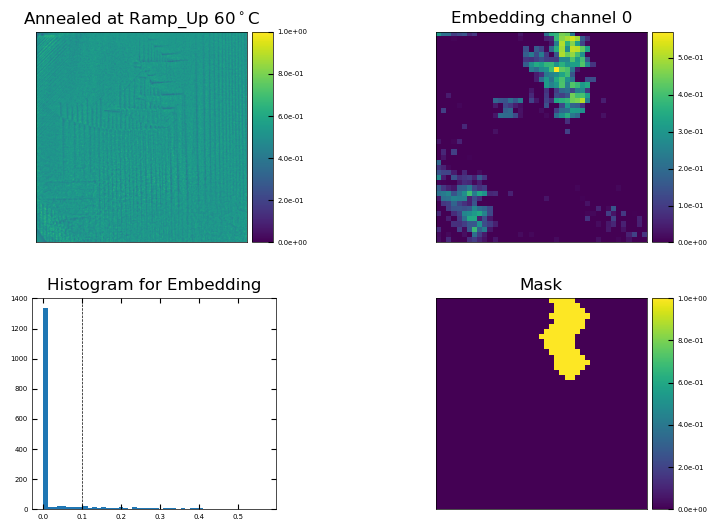

In [207]:
# If you don't want uncertanties, don't include `err_std`
mask = viz.make_mask(embedding,t=4,c=0,
                    dataset_key='/old_windows/windows_logdata',
                    save_folder='masking',eps=1)

<Figure size 640x480 with 0 Axes>

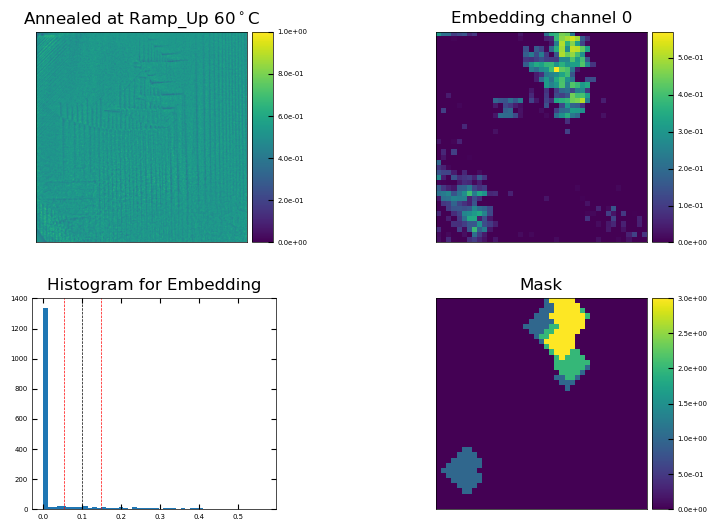

In [202]:
# if you include err_std, it will return three binary masks: original, lower bound, upper bound
mask,mask0,mask1 = viz.make_mask(embedding,t=4,c=0,
                                 dataset_key='/old_windows/windows_logdata',
                                 save_folder='masking',
                                 eps=1,err_std=0.5)

### Find relative areas

In [203]:
# Look at the movie generated in previous section; figure out which channels match domain patterns
channels = [0,4,6,7]

# Look at which channels are opposite of selected channels. These will be subtracted during cleaning
div_channels = [2,6,0,0]

# label the domain of each channel as keys and slope as value
legends_dict = {'<100> Horizontal':0,
                '<110> Left':45,
                '<100> Vertical':90,
                '<110> Right':-45}
# List format for labels
legends = list(legends_dict.keys())

100%|██████████| 43/43 [00:00<00:00, 62.32it/s]


<Figure size 640x480 with 0 Axes>

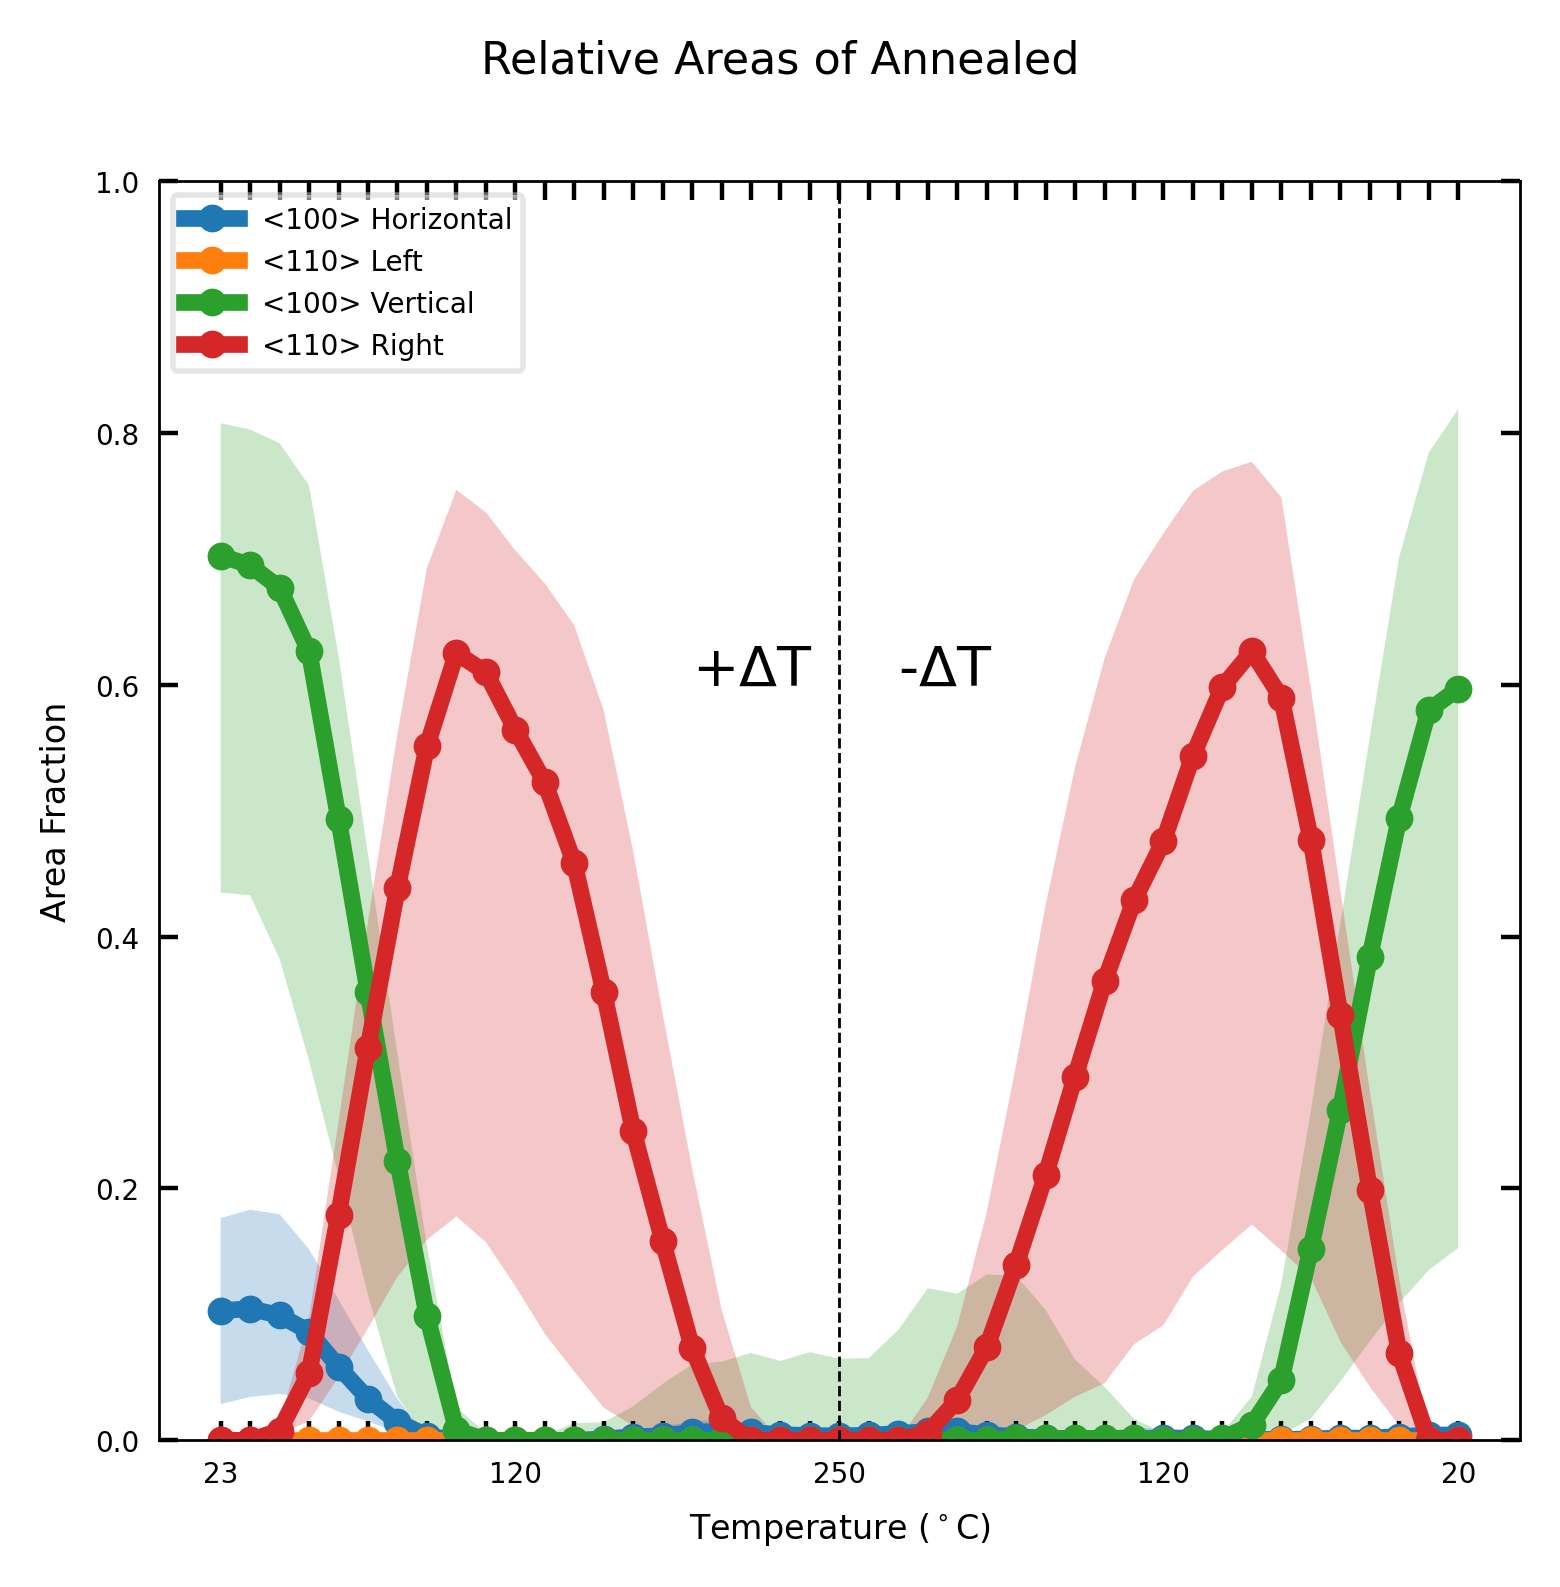

In [208]:
# If masked=True, relative areas are calculated from only the mask
# If masked = False, we will multiply the ma
rel_areas = viz.graph_relative_area(embedding, 
                                    dataset_key='/old_windows/windows_logdata',
                                    channels=channels,smoothing=5,
                                    clean_div=div_channels,
                                    legends=legends,
                                    masked=True,
                                    err_std=1,
                                    save_folder=f'./Relative Areas/')